# Importing Liberaries




In [1]:
import keras,os  #os: for dir
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout #CNN 
from tensorflow.keras.preprocessing.image import ImageDataGenerator  #for ImageDataGenerator
import matplotlib.pyplot as plt #for plotting 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #callback functions
import numpy as np #calculations
import gc #garbage collector


Using TensorFlow backend.


# Locating the Dataset

In [2]:
# Dataset:-
#             images (main folder)
#                 |__ Train 
#                 |__ Validate




images= os.chdir(r"C:\Users\Desktop\mix") #path of my image folder
images = os.getcwd() #returns current working directory 
# print(images)

train_dir = os.getcwd()
train_dir = os.path.join(images, 'train') #in the image folder it is locating train 
# print(train_dir)

validate_dir = os.getcwd()
validate_dir = os.path.join(images, 'validate') #in the image folder it is locating validate 
# print(validate_dir)




gc.collect() #garbage collection #collects unwanted variables to save the memory


#printing all the length of the directories
print('total image folders  :', len(os.listdir(images)))
print('total plant types in train_dir :', len(os.listdir(train_dir)))
print('total plant types in validate :', len(os.listdir(validate_dir)))

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\19378\\Desktop\\mix'

# Defining the categories

In [ ]:

categories = ["acer_campestre", "betula_nigra", "carya_cordiformis", "eucommia_ulmoides", "fraxinus_americana", "gleditsia_triacanthos",
             "juglans_nigra","liriodendron_tulipifera"]
print(len(categories))

# Data Preperation and Augmenting the images

In [2]:
train_image_generator = ImageDataGenerator(rescale=1./255,rotation_range=45,width_shift_range=.15,height_shift_range=.15,
                                            horizontal_flip=True,zoom_range=0.5) #generator for training data 

#calling the train_image_generator and deining the batch size (images to flow in batches), class_mode: categorical (since we have 8 different categories of leaf),
#target size = 128 (not above 128 because it will be easy for our system to train small size of images, not too less because system cannot train the features)
train_data_gen = train_image_generator.flow_from_directory(batch_size=128,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(128, 128),
                                                     class_mode='categorical')

#augments the images; like rotating, zooming in, scalling, which is defined in ImageDataGenerator,to get as many features as possible 
augmented_images = [train_data_gen[0][0][0] for i in range(6)]

#------------------------------------------------------------------------------------------------------------------
validate_image_generator = ImageDataGenerator(rescale=1./255) #generator for validation data
validate_data_gen = validate_image_generator.flow_from_directory(batch_size=128,
                                                 directory=validate_dir,
                                                 target_size=(128, 128),
                                                 class_mode='categorical')



Found 2136 images belonging to 8 classes.
Found 612 images belonging to 8 classes.


# Visualize the images

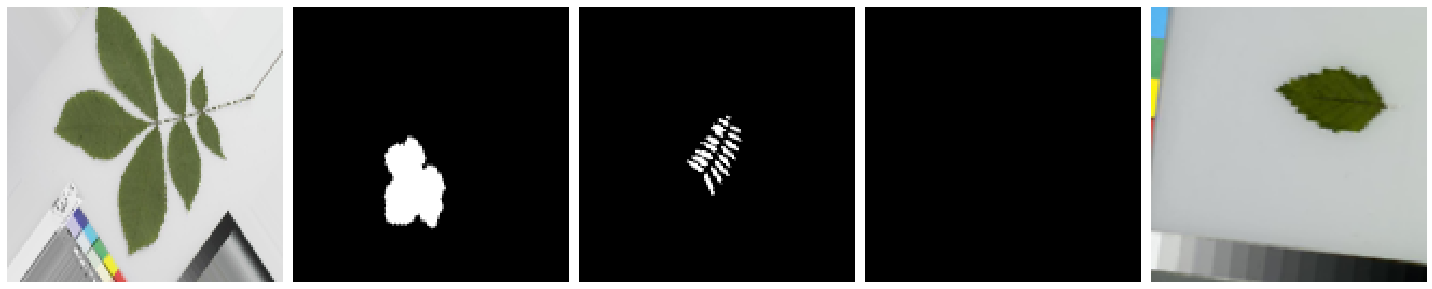

In [3]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
sample_training_images, _ = next(train_data_gen) #image called of train_data_gen
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20)) #Create a figure and a set of subplots.
    axes = axes.flatten() 
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.
    plt.show()
# plotImages(augmented_images)
plotImages(sample_training_images[:5])


# Defining Model

In [4]:
#Dropout is been applied to first and last max pool layers.
#Applying dropout will randomly set 20% of the neurons to zero during each training epoch,to avoid overfitting on the training dataset.

#the activation function is relu since it sets all the negative values to zero and it is better for our model.
#final dense layer has Softmax; since we are using multi class classification, it is best to use softmax because it turns numbers  into probabilities that sum to one
#so it will trigger the highest neuron and give the output.
model = Sequential()
model.add(Conv2D(input_shape=(128,128,3),filters=32,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(input_shape=(128,128,3),filters=32,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(input_shape=(128,128,3),filters=64,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(input_shape=(128,128,3),filters=128,kernel_size=(3,3), activation="relu"))
model.add(Conv2D(input_shape=(128,128,3),filters=128,kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=256,activation="relu"))
model.add(Dense(units=8,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)       

In [5]:
#Adam is used becaues it will best help us to get into global minima
#loss='categorical_crossentropy, because we have 8 categories, pass the metrics argument.
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics = ['acc'])

# Training the model

In [6]:
#EarlyStopping is used to monitor the model and triggers if the  model is overfitting  
stop = EarlyStopping (monitor='val_loss', mode='min', verbose=1, patience=3) #it will monitior val_loss, to go in descending order, it not then not more than 3 iterations;patience.
checkpoint = ModelCheckpoint("leaf_dl_vgg16.h5", monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1) #ModelCheckpoint; it is used to save the best set of model (we did not call it in this model)

#model.fit: calls to train the model, in epochs=15, verbose=1 (show purpose), callbacks = [EarlyStopping,ModelCheckpoint],steps_per_epoch: it will take 100 steps in every epoch
history = model.fit(train_data_gen,validation_data=validate_data_gen,callbacks= [stop],steps_per_epoch=100,
                         epochs=15,validation_steps=100,verbose=1)

Epoch 1/15
100/100 [==============================] - 553s 6s/step - loss: 1.8111 - acc: 0.2968 - val_loss: 1.6573 - val_acc: 0.4069
Epoch 2/15
100/100 [==============================] - 550s 5s/step - loss: 1.2406 - acc: 0.5165 - val_loss: 1.7717 - val_acc: 0.5065
Epoch 3/15
100/100 [==============================] - 552s 6s/step - loss: 0.9967 - acc: 0.6265 - val_loss: 1.8479 - val_acc: 0.4314
Epoch 4/15
100/100 [==============================] - 558s 6s/step - loss: 0.8685 - acc: 0.6734 - val_loss: 1.4025 - val_acc: 0.5359
Epoch 5/15
100/100 [==============================] - 561s 6s/step - loss: 0.7570 - acc: 0.7152 - val_loss: 2.4229 - val_acc: 0.4395
Epoch 6/15
100/100 [==============================] - 562s 6s/step - loss: 0.6981 - acc: 0.7349 - val_loss: 2.1991 - val_acc: 0.4902
Epoch 7/15
100/100 [==============================] - 559s 6s/step - loss: 0.6722 - acc: 0.7507 - val_loss: 2.1035 - val_acc: 0.4788
Epoch 00007: early stopping


In [ ]:
model.save('leaf_dl_vgg16_aug_mine.h5') #saving the model which is being trained in .h5 file, we can also save it in .model format

# Evaluating the model

In [3]:
#easy way to understand the model in the diagrametic form
acc = history.history['acc'] #the accuracy of the model.
print(acc)
val_acc = history.history['val_acc'] #form the trained model it is calling val_acc

loss=history.history['loss']#form the trained model it is calling loss
val_loss=history.history['val_loss']#form the trained model it is calling val_loss

epochs_range = range(7) #to show the steps of the epoch trained  

#to show Training Accuracy and Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#to show Training Accuracy and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

# Locating the data to test

C:\Users\19378\Desktop\test_leaf
total files : 5
Found 1 images belonging to 1 classes.


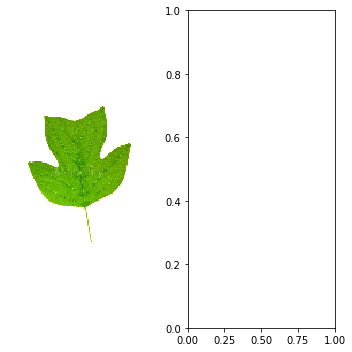

In [12]:
os.chdir(r"C:\Users\19378\Desktop\test_leaf") #location of the testing data
testing = os.getcwd() #returns current working directory 
print(testing)

# test_dir = os.path.join(testing, 'test_leaf')

print('total files :', len(os.listdir(testing))) 


test_datagen = ImageDataGenerator( rescale = 1.0/255. ) # Generator for our training data
test_generator = test_datagen.flow_from_directory(testing,class_mode='binary',target_size=(128, 128)) #flow_from_directory method load images from the disk, applies rescaling, and resizes the images into the required dimensions.
print(test_generator)


#plotting the image to be tested
sample_training_images, _ = next(test_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 2, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    

plotImages(sample_training_images[:])


# Testing

In [13]:
new_model = tf.keras.models.load_model('leaf_dl_vgg16_aug_mine.h5') #loading the model which was pre trained by us.

predictions = new_model.predict(test_generator) #Generates output predictions for the input samples.

a=predictions[0]
print(a)
index_max = np.argmax(a) #Returns the indices of the maximum values along an axis from the model.
print(index_max) 
print(categories[index_max]) #the name of the category which got the highest value.


#acc = model.evaluate(train_data_gen, test_generator, verbose=0) #this evaluates the model

c:\users\19378\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


[1.42772915e-05 9.65463931e-10 6.67815414e-10 1.67805003e-04
 4.99765090e-11 1.50689792e-17 6.08659087e-12 9.99817908e-01]
7
liriodendron_tulipifera


# Beautification/ Output

In [14]:
thisdict = {0:"Name : Acer \nFamily: Campestre \nType: Deciduous \nEdible uses: none \nMaterial uses: Used for packing fruits \nMedicinal uses: none \nEnvironmental Tolerances: Strong Wind \nLife Cycle: Perennial", 
             1:"Name : Betula nigra \nFamily : Betulaceae \nType: Deciduous \nEdible uses: Sap - raw or cooked \nMaterial uses: sometimes used for furniture \nMedicinal uses: Chewed, or used as an infusion,  treatment of dysentery \nEnvironmental Tolerances: sensitive \nLife Cycle: Perennial",
              2:"Name : Carya cordiformis \nFamily : Juglandaceae \nType: Deciduous \nEdible uses: raw or cooked \nMaterial uses: Used as an illuminant in oil lamps \nMedicinal uses: Treatment of rheumatism \nEnvironmental Tolerances: sensitive \nLife Cycle: Perennial",
               3: "Name : Eucommia ulmoides \nFamily : Eucommiaceae \nType: Deciduous \nEdible uses: Young leaves \nMaterial uses: The leaves contain 3% dry weight of gutta-percha, a non-elastic rubber, used for insulation of electrical wires \nMedicinal uses: Treatment of reduction in blood pressure \nEnvironmental Tolerances: sensitive \nLife Cycle: Perennial",
               4: "Name : Fraxinus american \nFamily : Fraxinus \nType: Deciduous \nEdible uses: Yes \nMaterial uses: none \nMedicinal uses: Decoction of the leaves as a laxative and general tonic for women after childbirth \nEnvironmental Tolerances: sensitive \nLife Cycle: Perennial",
               5: "Name : Gleditsia triacanthos \nFamily : Leguminosae \nType: Deciduous \nEdible uses: none, The plant contains potentially toxic compounds \nMaterial uses: none \nMedicinal uses: The juice of the pods is antiseptic \nEnvironmental Tolerances: Salinity and Drought \nLife Cycle: Perennial",
               6: "Name : Juglans nigra \nFamily : Juglandaceae \nType: Deciduous \nEdible uses: none, The plant has occasionally been known to cause contact dermatitis in humans; toxic \nMaterial uses: none \nMedicinal uses: none \nEnvironmental Tolerances: sensitive \nLife Cycle: Perennial",
               7: "Name : Liriodendron tulipifera \nFamily : Magnoliaceae \nType: Deciduous \nEdible uses: none \nMaterial uses: none \nMedicinal uses: A gold-coloured dye is obtained from it \nEnvironmental Tolerances: sensitive \nLife Cycle: Perennial",}
print(thisdict[index_max])


Name : Liriodendron tulipifera 
Family : Magnoliaceae 
Type: Deciduous 
Edible uses: none 
Material uses: none 
Medicinal uses: A gold-coloured dye is obtained from it 
Environmental Tolerances: sensitive 
Life Cycle: Perennial
